# Autoencoders

In [18]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import cut_classical_path, cut_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import tune_hyperparameters, load_optimal_params

## Data Loading

### Load Audio & Extract Features

In [20]:
# Load samples from both styles
n_samples = 5000
X_classical_raw = load_data(cut_classical_path, n_samples=n_samples)
X_jazz_raw = load_data(cut_jazz_path, n_samples=n_samples)

# Concatenate (train on all samples)
X_raw = np.concatenate((X_classical_raw, X_jazz_raw))

# Print feature shape
print(f"{X_raw.shape = }")

100 %
100 %
X_raw.shape = (1019, 67, 128, 1)


### Train - Validation - Test Split

In [21]:
# Fraction of data to keep apart for validation
test_size = round(0.1 * len(X_raw))
val_size = test_size
# Perform split
X_raw_train, X_raw_test = train_test_split(X_raw, test_size=test_size)
X_raw_train, X_raw_val = train_test_split(X_raw_train, test_size=val_size)
# Verify split shapes
print(f"{X_raw_train.shape = }")
print(f"{X_raw_test.shape = }")
print(f"{X_raw_val.shape = }")

X_raw_train.shape = (815, 67, 128, 1)
X_raw_test.shape = (102, 67, 128, 1)
X_raw_val.shape = (102, 67, 128, 1)


In [22]:
input_shape = X_raw_train.shape[1:]
print(f"{input_shape = }")

input_shape = (67, 128, 1)


### Normalize Features

In [23]:
# Perform normalization
X_train, X_val, X_test = normalize_features(X_raw_train, X_raw_val=X_raw_val, X_raw_test=X_raw_test)

print(f"{X_train.shape = }")
print(f"{X_val.shape = }")
print(f"{X_test.shape = }")

X_train.shape = (815, 67, 128, 1)
X_val.shape = (102, 67, 128, 1)
X_test.shape = (102, 67, 128, 1)


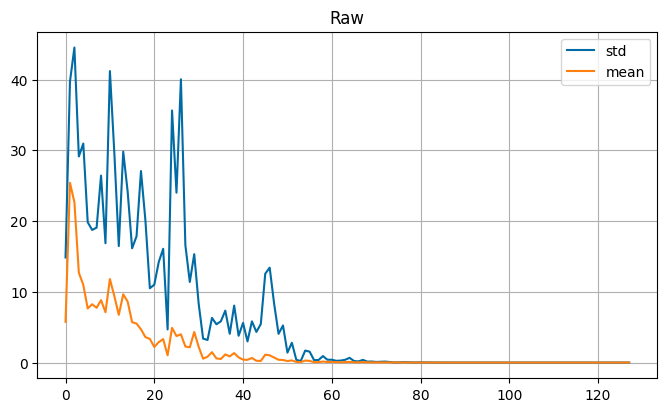

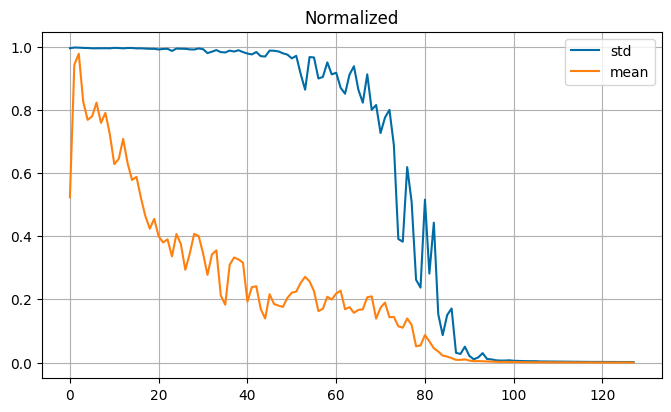

In [24]:
# See the effect of normalization
fig, ax = make_figax()
ax.plot(np.std(X_raw_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_raw_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_raw_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Raw")
plt.show()


fig, ax = make_figax()
ax.plot(np.std(X_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Normalized")
plt.show()

## Autoencoders

### Test Script

In [25]:
nop = lambda x: x

def test_autoencoder(autoencoder, test_set = X_test, plot_transforms = True, plot_raw_transforms = True, plot_waveforms = True):
  # Pick sample at random
  print("Picking Sample")
  choice = np.random.choice(len(test_set))
  x = test_set[choice]

  # Autencoder
  print("Autencoding")
  x_hat = np.array(autoencoder(x.reshape((1, *x.shape))))

  if plot_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x, fn=nop)
    ax.set_title("Original Preprocessed Spectrum")
    fig, ax = plot_spectral_feature(x_hat, fn=nop)
    ax.set_title("Reconstructed Preprocessed Spectrum")
    plt.show()

  # Postprocess
  print("Postprocessing")
  x_raw = denormalize_features(x.reshape((1, *x.shape)))[0]
  x_raw_hat = denormalize_features(x_hat.reshape((1, *x.shape)))[0]

  if plot_raw_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x_raw)
    ax.set_title("Original Raw Spectrum")
    fig, ax = plot_spectral_feature(x_raw_hat)
    ax.set_title("Reconstructed Raw Spectrum")
    plt.show()

  # Reconstruct Audio
  print("Reconstructing Audio")
  s = np.squeeze(compute_imels(x_raw))
  s_hat = np.squeeze(compute_imels(x_raw_hat))

  if plot_waveforms:
    fig, ax = plot_audio(s)
    ax.set_title("Original Waveform")
    fig, ax = plot_audio(s_hat)
    ax.set_title("Reconstructed Waveform")
    plt.show()

  # Play audio
  print("Original Audio")
  player = play_audio(s)
  print("Reconstructed Audio")
  player = play_audio(s_hat)
  print()

In [26]:
def free_memory(autoencoder):
  krs.backend.clear_session()
  del autoencoder.encoder
  del autoencoder.decoder
  del autoencoder
  krs.backend.clear_session()

In [27]:
os.makedirs(models_path, exist_ok = True)
def save_autoencoder(autoencoder, params, history, name):
    # Define and make directory
    autoencoder_path = os.path.join(models_path, name)
    os.makedirs(autoencoder_path, exist_ok = True)
    
    # Save parameters
    with open(os.path.join(autoencoder_path, "params.json"), "w") as params_file:
        json.dump(params, params_file)
        
    # Save history
    with open(os.path.join(autoencoder_path, "history.json"), "w") as history_file:
        if not isinstance(history, dict):
            history = history.history
        json.dump(history, history_file)
    
    # Save model
    autoencoder.save(os.path.join(autoencoder_path, "model.keras"))

def load_autoencoder(name, load_model = True):
    # Define path
    autoencoder_path = os.path.join(models_path, name)
    
    # Load parameters
    with open(os.path.join(autoencoder_path, "params.json"), "r") as params_file:
        params = json.load(params_file)
    
    # Load history
    with open(os.path.join(autoencoder_path, "history.json"), "r") as history_file:
        history = json.load(history_file)
    
    # Load model
    autoencoder = None
    if load_model:
        autoencoder = krs.models.load_model(os.path.join(autoencoder_path, "model.keras"))
    
    return autoencoder, params, history

### Convolutional Autoencoder

In [28]:
from models.autoencoders import Conv2DAutoencoder

In [29]:
default_params = {
    "feature_shape": input_shape,
    "compression": 8,
    "kernel_size": 3,
    "conv_depth": 1,
    "input_chans_multiplier": 1,
    "skip_connection": True,
    "pooling_type": "average",
}

compile_kwargs = {
    "optimizer": "adam",
    "loss": "mae",
}


In [13]:
# Test training
autoencoder = Conv2DAutoencoder(**default_params)
autoencoder.compile(**compile_kwargs)
history = autoencoder.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_val, X_val), verbose=1)

2023-11-17 23:38:28.475451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 23:38:28.486019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 23:38:28.488842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


2023-11-17 23:38:33.628680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2023-11-17 23:38:35.062025: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f063b4443d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-17 23:38:35.062067: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-17 23:38:35.068067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-17 23:38:35.176867: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 8s 9ms/step - loss: 0.5663 - val_loss: 0.2416
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.2190 - val_loss: 0.2110
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1994 - val_loss: 0.1984
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1925 - val_loss: 0.1953
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1910 - val_loss: 0.1944
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1905 - val_loss: 0.1940
Epoch 7/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1902 - val_loss: 0.1937
Epoch 8/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1899 - val_loss: 0.1935
Epoch 9/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1898 - val_loss: 0.1934
Epoch 10/10
250/250 [==============================] - 1s 5ms/step - loss: 0.1897 - val_loss: 0.1933


In [31]:
# Hyperparameter tuning
results_path = os.path.join("./results/Conv2DAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "input_chans_multiplier",
    "conv_depth",
    "skip_connection",
    "kernel_size",
    "pooling_type",
])
vals = np.array([
    [1, 2, 4, 8],
    [1, 2, 3],
    [True, False],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key = "val_loss"
epochs = 250
passes = 1

In [17]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_train,
    X_train,
    Conv2DAutoencoder,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_val,
    y_val=X_val,
    results_path=results_path,
    epochs=epochs,
    compile_kwargs=compile_kwargs,
    verbose=False,
    do_random=True,
    random_attempts=25,
)

Optimizing for default parameters
Epoch 1/250
250/250 [==============================] - 5s 8ms/step - loss: 0.2727 - val_loss: 0.2020
Epoch 2/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1944 - val_loss: 0.1961
Epoch 3/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1914 - val_loss: 0.1945
Epoch 4/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1905 - val_loss: 0.1939
Epoch 5/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1901 - val_loss: 0.1936
Epoch 6/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1898 - val_loss: 0.1934
Epoch 7/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1897 - val_loss: 0.1933
Epoch 8/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1896 - val_loss: 0.1932
Epoch 9/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1896 - val_loss: 0.1931
Epoch 10/250
250/250 [==============================] - 1

250/250 [==============================] - 2s 9ms/step - loss: 0.1071 - val_loss: 0.1143
Epoch 23/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1057 - val_loss: 0.1140
Epoch 24/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1051 - val_loss: 0.1130
Epoch 25/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1049 - val_loss: 0.1130
Epoch 26/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1034 - val_loss: 0.1119
Epoch 27/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1028 - val_loss: 0.1125
Epoch 28/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1024 - val_loss: 0.1114
Epoch 29/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1020 - val_loss: 0.1104
Epoch 30/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1012 - val_loss: 0.1111
Epoch 31/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1008 - val_loss: 

Epoch 46/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1094 - val_loss: 0.1200
Epoch 47/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1086 - val_loss: 0.1206
Epoch 48/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1083 - val_loss: 0.1194
Epoch 49/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1078 - val_loss: 0.1192
Epoch 50/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1075 - val_loss: 0.1199
Epoch 51/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1072 - val_loss: 0.1188
Epoch 52/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1065 - val_loss: 0.1194
Epoch 53/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1065 - val_loss: 0.1181
Epoch 54/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1059 - val_loss: 0.1181
Epoch 55/250
250/250 [==============================] - 3s 12ms/step - lo

250/250 [==============================] - 1s 5ms/step - loss: 0.0957 - val_loss: 0.0975
Epoch 40/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0955 - val_loss: 0.0970
Epoch 41/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0955 - val_loss: 0.0963
Epoch 42/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0951 - val_loss: 0.0976
Epoch 43/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0947 - val_loss: 0.0962
Epoch 44/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0947 - val_loss: 0.0953
Epoch 45/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0945 - val_loss: 0.0971
Epoch 46/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0945 - val_loss: 0.0948
Epoch 47/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0942 - val_loss: 0.0957
Epoch 48/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0938 - val_loss: 

250/250 [==============================] - 5s 20ms/step - loss: 0.1434 - val_loss: 0.1465
Epoch 16/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1423 - val_loss: 0.1458
Epoch 17/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1408 - val_loss: 0.1434
Epoch 18/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1392 - val_loss: 0.1428
Epoch 19/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1385 - val_loss: 0.1435
Epoch 20/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1374 - val_loss: 0.1410
Epoch 21/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1358 - val_loss: 0.1405
Epoch 22/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1349 - val_loss: 0.1413
Epoch 23/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1342 - val_loss: 0.1379
Epoch 24/250
250/250 [==============================] - 5s 20ms/step - loss: 0.1328 - 

250/250 [==============================] - 3s 12ms/step - loss: 0.1266 - val_loss: 0.1328
Epoch 26/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1260 - val_loss: 0.1324
Epoch 27/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1251 - val_loss: 0.1315
Epoch 28/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1242 - val_loss: 0.1306
Epoch 29/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1230 - val_loss: 0.1303
Epoch 30/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1225 - val_loss: 0.1310
Epoch 31/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1214 - val_loss: 0.1286
Epoch 32/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1208 - val_loss: 0.1287
Epoch 33/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1199 - val_loss: 0.1281
Epoch 34/250
250/250 [==============================] - 3s 12ms/step - loss: 0.1189 - 

Epoch 18/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1084 - val_loss: 0.1137
Epoch 19/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1071 - val_loss: 0.1121
Epoch 20/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1062 - val_loss: 0.1125
Epoch 21/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1055 - val_loss: 0.1115
Epoch 22/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1042 - val_loss: 0.1099
Epoch 23/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1037 - val_loss: 0.1095
Epoch 24/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1025 - val_loss: 0.1102
Epoch 25/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1018 - val_loss: 0.1082
Epoch 26/250
250/250 [==============================] - 2s 9ms/step - loss: 0.1011 - val_loss: 0.1078
Epoch 27/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1007

In [22]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 1, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average'}
optimal_loss = 0.08437574654817581


In [24]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        Conv2DAutoencoder,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        compile_kwargs=compile_kwargs,
        verbose=False,
        do_random=False,
    )

Training model for input_chans_multiplier = 1
Epoch 1/250
250/250 [==============================] - 4s 7ms/step - loss: 0.1587 - val_loss: 0.1398
Epoch 2/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1363 - val_loss: 0.1297
Epoch 3/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1302 - val_loss: 0.1256
Epoch 4/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1266 - val_loss: 0.1232
Epoch 5/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1242 - val_loss: 0.1208
Epoch 6/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1224 - val_loss: 0.1191
Epoch 7/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1209 - val_loss: 0.1183
Epoch 8/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1198 - val_loss: 0.1166
Epoch 9/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1186 - val_loss: 0.1157
Epoch 10/250
250/250 [=======================

250/250 [==============================] - 2s 7ms/step - loss: 0.0921 - val_loss: 0.0910
Epoch 36/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0915 - val_loss: 0.0908
Epoch 37/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0913 - val_loss: 0.0897
Epoch 38/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0910 - val_loss: 0.0902
Epoch 39/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0902 - val_loss: 0.0890
Epoch 40/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0902 - val_loss: 0.0887
Epoch 41/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0896 - val_loss: 0.0891
Epoch 42/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0894 - val_loss: 0.0877
Epoch 43/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0889 - val_loss: 0.0883
Epoch 44/250
250/250 [==============================] - 2s 7ms/step - loss: 0.0887 - val_loss: 

250/250 [==============================] - 12s 46ms/step - loss: 0.1551 - val_loss: 0.1527
Epoch 13/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1544 - val_loss: 0.1530
Epoch 14/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1540 - val_loss: 0.1526
Epoch 15/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1534 - val_loss: 0.1521
Epoch 16/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1527 - val_loss: 0.1514
Epoch 17/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1526 - val_loss: 0.1511
Epoch 18/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1520 - val_loss: 0.1511
Epoch 19/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1512 - val_loss: 0.1512
Epoch 20/250
250/250 [==============================] - 12s 46ms/step - loss: 0.1510 - val_loss: 0.1495
Epoch 21/250
250/250 [==============================] - 12s 46ms/step - loss:

250/250 [==============================] - 1s 5ms/step - loss: 0.0964 - val_loss: 0.0943
Epoch 41/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0960 - val_loss: 0.0935
Epoch 42/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0960 - val_loss: 0.0934
Epoch 43/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0958 - val_loss: 0.0935
Epoch 44/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0957 - val_loss: 0.0945
Epoch 45/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0955 - val_loss: 0.0930
Epoch 46/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0952 - val_loss: 0.0928
Epoch 47/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0950 - val_loss: 0.0940
Epoch 48/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0949 - val_loss: 0.0922
Epoch 49/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0949 - val_loss: 

Epoch 66/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0897 - val_loss: 0.0877
Epoch 67/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0896 - val_loss: 0.0869
Epoch 68/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0895 - val_loss: 0.0868
Epoch 69/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0895 - val_loss: 0.0868
Epoch 70/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0943 - val_loss: 0.0872
Epoch 71/250
250/250 [==============================] - 1s 5ms/step - loss: 0.0891 - val_loss: 0.0870
Training model for conv_depth = 2
Epoch 1/250
250/250 [==============================] - 7s 10ms/step - loss: 0.1728 - val_loss: 0.1545
Epoch 2/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1491 - val_loss: 0.1396
Epoch 3/250
250/250 [==============================] - 2s 8ms/step - loss: 0.1361 - val_loss: 0.1273
Epoch 4/250
250/250 [=============================

250/250 [==============================] - 3s 10ms/step - loss: 0.1952 - val_loss: 0.1924
Epoch 3/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1952 - val_loss: 0.1923
Epoch 4/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1951 - val_loss: 0.1921
Epoch 5/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1950 - val_loss: 0.1920
Epoch 6/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1948 - val_loss: 0.1918
Epoch 7/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1947 - val_loss: 0.1919
Epoch 8/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1946 - val_loss: 0.1919
Epoch 9/250
250/250 [==============================] - 3s 10ms/step - loss: 0.1947 - val_loss: 0.1919
Optimal conv_depth = 1
Training model for kernel_size = 3
Epoch 1/250
250/250 [==============================] - 5s 9ms/step - loss: 0.1700 - val_loss: 0.1538
Epoch 2/250
250/250 [================

250/250 [==============================] - 1s 5ms/step - loss: 0.1136 - val_loss: 0.1111
Epoch 10/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1123 - val_loss: 0.1097
Epoch 11/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1115 - val_loss: 0.1089
Epoch 12/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1103 - val_loss: 0.1081
Epoch 13/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1096 - val_loss: 0.1073
Epoch 14/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1089 - val_loss: 0.1064
Epoch 15/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1082 - val_loss: 0.1067
Epoch 16/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1074 - val_loss: 0.1052
Epoch 17/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1068 - val_loss: 0.1051
Epoch 18/250
250/250 [==============================] - 1s 5ms/step - loss: 0.1063 - val_loss: 

250/250 [==============================] - 1s 5ms/step - loss: 0.0902 - val_loss: 0.0886
Optimal pooling_type = average


TypeError: '>' not supported between instances of 'numpy.ndarray' and 'numpy.str_'

In [25]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 1, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average'}
optimal_loss = 0.08437574654817581


In [34]:
# Load optimal hyperparameters from tuning process
optimal_params, optimal_loss = load_optimal_params(results_path, loss_key)

In [35]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 2, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average'}
optimal_loss = 0.07772304862737656


In [36]:
# Retrain with optimal params
autoencoder = Conv2DAutoencoder(**optimal_params)
autoencoder.compile(**compile_kwargs)
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = autoencoder.fit(X_train, X_train, epochs=250, shuffle=True, validation_data=(X_val, X_val), callbacks=[earlystopping], verbose=1)

Epoch 1/10
26/26 [==============================] - 6s 175ms/step - loss: 0.2167 - val_loss: 0.2041
Epoch 2/10
26/26 [==============================] - 4s 149ms/step - loss: 0.2165 - val_loss: 0.2041
Epoch 3/10
26/26 [==============================] - 3s 120ms/step - loss: 0.2165 - val_loss: 0.2041
Epoch 4/10
26/26 [==============================] - 3s 115ms/step - loss: 0.2165 - val_loss: 0.2041
Epoch 5/10
26/26 [==============================] - 3s 124ms/step - loss: 0.2157 - val_loss: 0.1983
Epoch 6/10
26/26 [==============================] - 3s 124ms/step - loss: 0.2022 - val_loss: 0.1817
Epoch 7/10
26/26 [==============================] - 3s 123ms/step - loss: 0.1915 - val_loss: 0.1751
Epoch 8/10
26/26 [==============================] - 3s 133ms/step - loss: 0.1838 - val_loss: 0.1705
Epoch 9/10
26/26 [==============================] - 4s 147ms/step - loss: 0.1784 - val_loss: 0.1647
Epoch 10/10
26/26 [==============================] - 4s 141ms/step - loss: 0.1741 - val_loss: 0.1620

Picking Sample
Autencoding
Plotting transforms


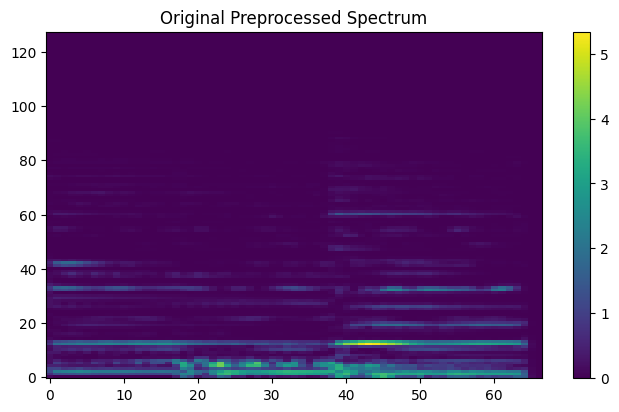

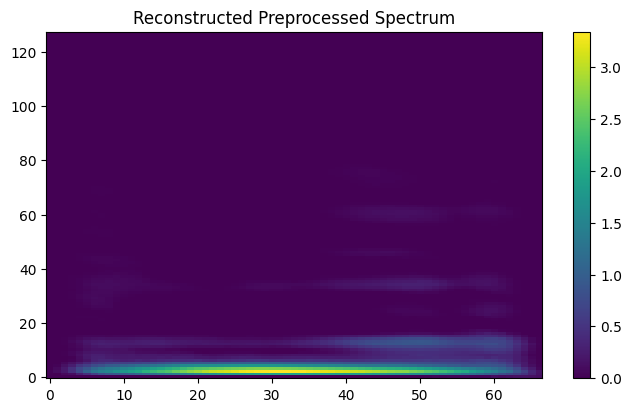

Postprocessing
Plotting transforms


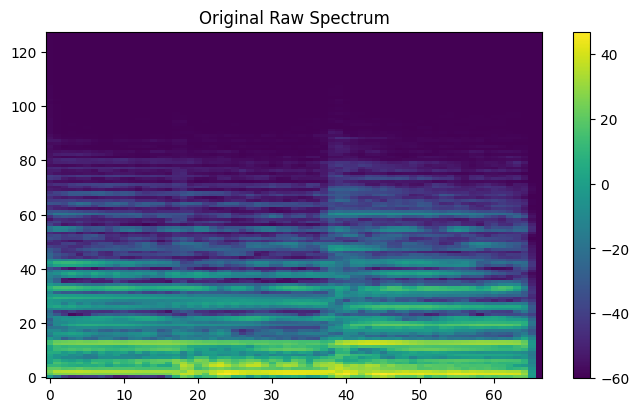

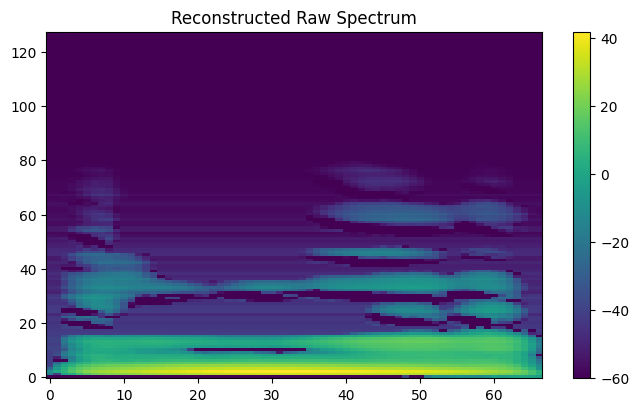

Reconstructing Audio


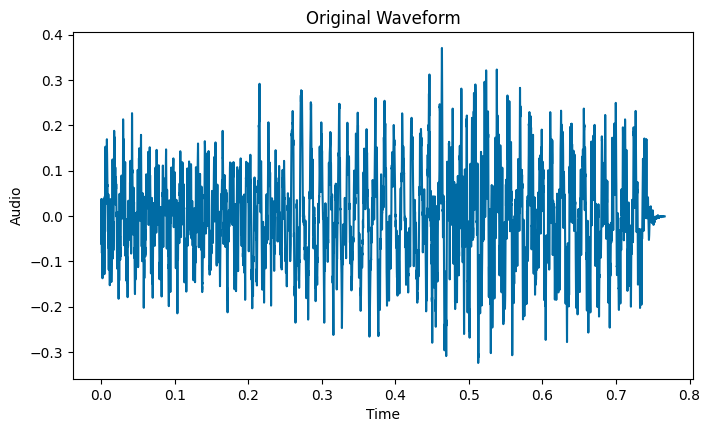

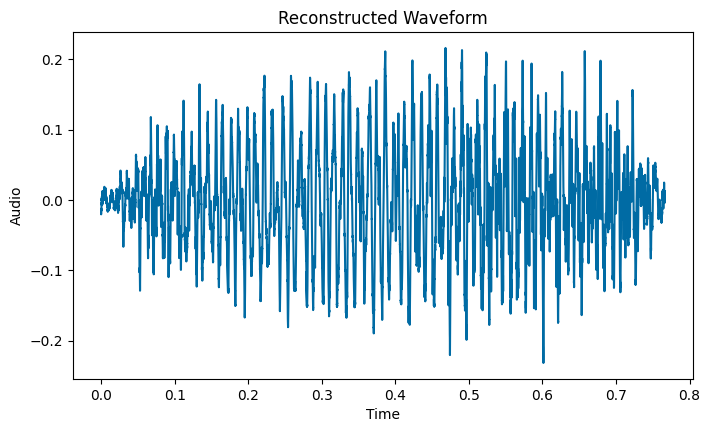

Original Audio


Reconstructed Audio


In [37]:
# Test autoencoder
test_autoencoder(autoencoder)

### Variational Autencoder

In [21]:
from models.autoencoders import VariationalAutoencoder

In [22]:
try:
    default_params = optimal_params.copy()
    default_params["kl_reg"] = 1
except:
    print("WARNING: Optimal params are undefined")
    default_params = {
        "feature_shape": input_shape,
        "compression": 8,
        "kernel_size": 5,
        "conv_depth": 1,
        "input_chans_multiplier": 1,
        "skip_connection": True,
        "pooling_type": "average",
        "kl_reg": 1,
    }

In [23]:
autoencoder = VariationalAutoencoder(**default_params)
autoencoder.compile(optimizer="adam")
history = autoencoder.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_val, X_val), verbose=1)

Epoch 1/10
250/250 [==============================] - 6s 10ms/step - loss: 0.5432 - r_loss: 0.1954 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 2/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 3/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 4/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 5/10
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 6/10
250/250 [==============================] - 2s 7ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 

In [24]:
# Hyperparameter tuning
results_path = os.path.join("./results/VariationalAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "kl_reg",
    "input_chans_multiplier",
    "conv_depth",
    "skip_connection",
    "kernel_size",
    "pooling_type",
])
vals = np.array([
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    [1, 2, 4],
    [1, 2, 3],
    [True, False],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key="val_r_loss"
epochs = 250
passes = 3
optimal_params = default_params.copy()

In [25]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_train,
    X_train,
    VariationalAutoencoder,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_val,
    y_val=X_val,
    results_path=results_path,
    epochs=epochs,
    compile_kwargs=compile_kwargs,
    verbose=True,
    do_random=True,
    random_attempts=25,
)

Optimizing for default parameters
Epoch 1/250
250/250 [==============================] - 5s 9ms/step - loss: 0.5640 - r_loss: 0.2087 - kl_loss: 0.3553 - val_loss: 0.5616 - val_r_loss: 0.1967 - val_kl_loss: 0.3650
Epoch 2/250
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 3/250
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 4/250
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
Epoch 5/250
250/250 [==============================] - 2s 6ms/step - loss: 0.5428 - r_loss: 0.1951 - kl_loss: 0.3477 - val_loss: 0.5616 - val_r_loss: 0.1966 - val_kl_loss: 0.3650
loss = 0.19663791358470917
Optimizing for random choices
Epoch 1/250
25

250/250 [==============================] - 2s 9ms/step - loss: 0.5257 - r_loss: 0.1744 - kl_loss: 0.3513 - val_loss: 0.5430 - val_r_loss: 0.1740 - val_kl_loss: 0.3690
Epoch 4/250
250/250 [==============================] - 2s 9ms/step - loss: 0.5222 - r_loss: 0.1696 - kl_loss: 0.3526 - val_loss: 0.5393 - val_r_loss: 0.1688 - val_kl_loss: 0.3705
Epoch 5/250
250/250 [==============================] - 2s 9ms/step - loss: 0.5184 - r_loss: 0.1645 - kl_loss: 0.3539 - val_loss: 0.5359 - val_r_loss: 0.1636 - val_kl_loss: 0.3723
Epoch 6/250
250/250 [==============================] - 3s 10ms/step - loss: 0.5156 - r_loss: 0.1608 - kl_loss: 0.3548 - val_loss: 0.5340 - val_r_loss: 0.1610 - val_kl_loss: 0.3730
Epoch 7/250
250/250 [==============================] - 2s 9ms/step - loss: 0.5141 - r_loss: 0.1587 - kl_loss: 0.3554 - val_loss: 0.5328 - val_r_loss: 0.1602 - val_kl_loss: 0.3726
Epoch 8/250
250/250 [==============================] - 2s 9ms/step - loss: 0.5131 - r_loss: 0.1572 - kl_loss: 0.3558

KeyboardInterrupt: 

In [ ]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

In [ ]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        VariationalAutoencoder,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        compile_kwargs=compile_kwargs,
        verbose=True,
        do_random=False,
    )

In [ ]:
# TODO: retrain with all data & optimal parameters

Picking Sample
Autencoding
Plotting transforms


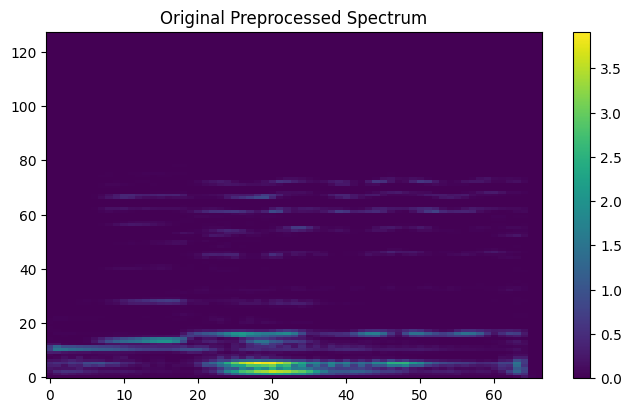

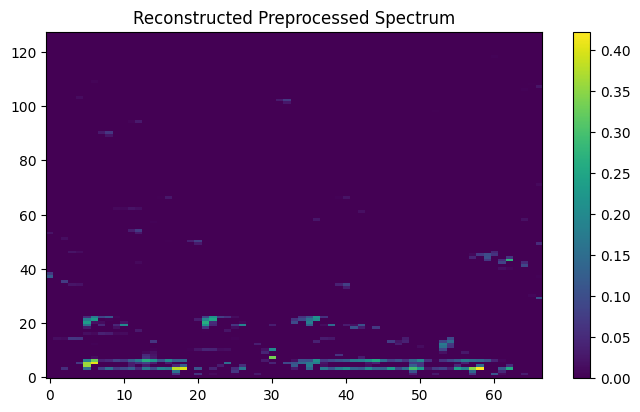

Postprocessing
Plotting transforms


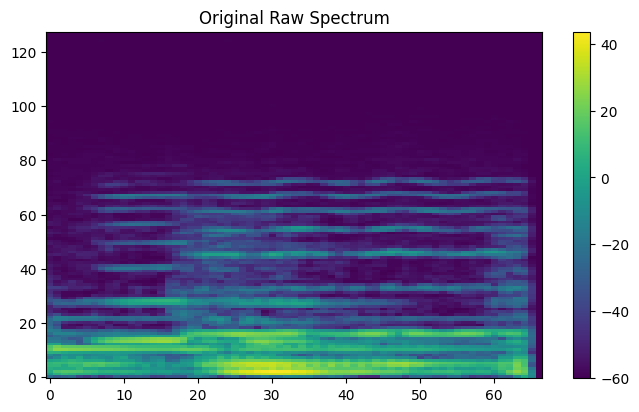

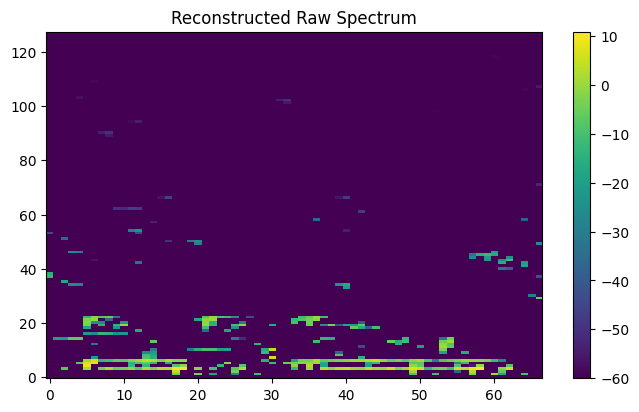

Reconstructing Audio


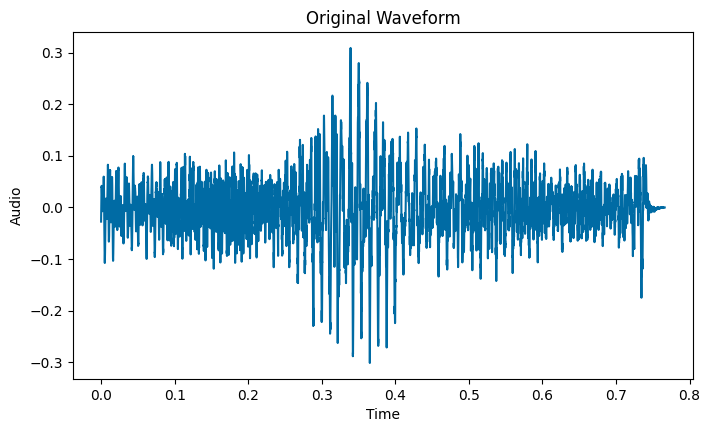

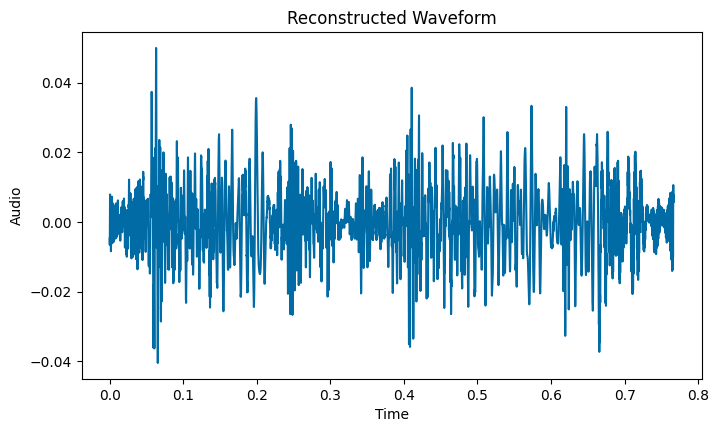

Original Audio


Reconstructed Audio


In [50]:
test_autoencoder(autoencoder)

In [ ]:
# TODO: Test creating multiple variations of the same input data


### GAN Autoencoder

In [12]:
from models.autoencoders import GANGenerator, GANDiscriminator
from models.layers import GAN

In [13]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    
    # Instantiate model
    generator = GANGenerator(**g_params)
    discriminator = GANDiscriminator(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [16]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 8,
    "g_kernel_size": 3,
    "g_conv_depth": 1,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": True,
    "g_pooling_type": "average",
    "g_gan_reg": 0.1,
    "g_c_reg": 0.1,
    "g_s_reg": 0.1,
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

In [17]:
# Test training
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)
history = gan.fit(X_train, X_train, epochs=1, shuffle=True, verbose=1, validation_data=(X_val, X_val))

g_params = {'feature_shape': (67, 128, 1), 'compression': 8, 'kernel_size': 3, 'conv_depth': 1, 'input_chans_multiplier': 1, 'skip_connection': True, 'pooling_type': 'average', 'gan_reg': 0.1, 'c_reg': 0.1, 's_reg': 0.1}
d_params = {'feature_shape': (67, 128, 1), 'mlp_layers': 2, 'conv_compression': 8, 'conv_kernel_size': 3, 'conv_pooling_type': 'max'}
26/26 [==============================] - 15s 277ms/step - loss: 3.3369 - r_loss: 2.1871 - gan_loss: 3.7059 - c_loss: 2.6189 - s_loss: 5.1729 - d_loss: 1.4166 - val_loss: 1.5153 - val_r_loss: 0.8766 - val_gan_loss: 3.3743 - val_c_loss: 0.9725 - val_s_loss: 2.0397 - val_d_loss: 0.1439


In [ ]:
# Hyperparameter tuning
results_path = os.path.join("./results/GANAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "input_chans_multiplier",
    "conv_depth",
    "skip_connection",
    "kernel_size",
    "pooling_type",
])
vals = np.array([
    [1, 2, 4, 8],
    [1, 2, 3],
    [True, False],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key = "val_loss"
epochs = 1
passes = 5